In [36]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np

import re

stop_words = set(stopwords.words('english'))

In [27]:
yelp_df = pd.read_json('yelp_reviews_first_mil.json', lines=True)[:10000]
reviews = yelp_df["text"].tolist()
star_ratings = yelp_df["stars"].tolist()

In [28]:
processed_reviews = [word_tokenize(re.sub(r'[^a-zA-Z0-9 ]', '', review.lower())) for review in reviews]
for i in range(len(processed_reviews)):
    processed_reviews[i] = [w for w in processed_reviews[i] if not w in stop_words]
#Word2Vec<vocab=33550, vector_size=100, alpha=0.025>
word2vec_model = Word2Vec(processed_reviews, vector_size=100, window=5, min_count=1, workers=4)

In [29]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

In [30]:
# Convert each sentence to its vector representation
sentence_vectors = [average_word_vectors(sentence, word2vec_model, word2vec_model.wv.index_to_key, 100) 
                    for sentence in processed_reviews]

In [32]:
clusters = 5
kmeans = KMeans(n_clusters=clusters, random_state=42)
cluster_labels = kmeans.fit_predict(sentence_vectors)

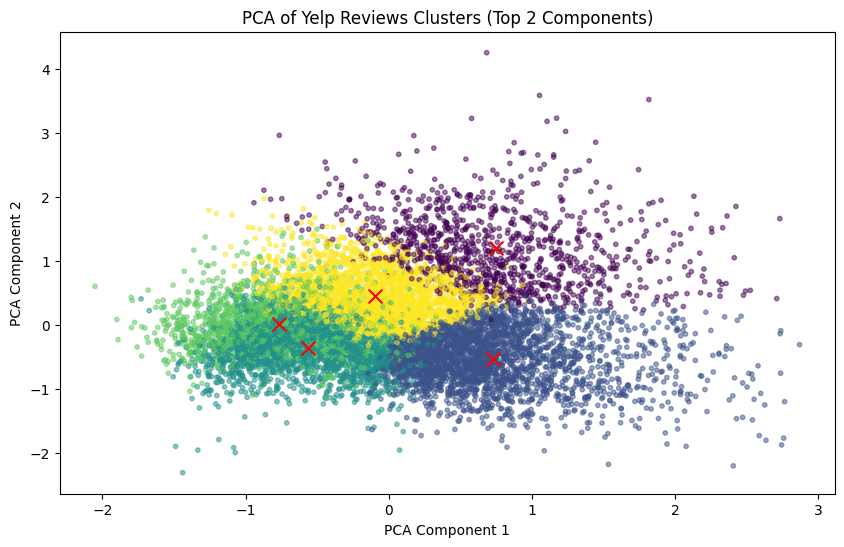

In [37]:
# Add cluster labels to DataFrame
yelp_df["cluster_label"] = cluster_labels

pca = PCA(n_components=100, random_state=42)
pca.fit(sentence_vectors)

# Select the top k components that contribute the most variance
explained_variance_ratio = pca.explained_variance_ratio_
sorted_indices = np.argsort(explained_variance_ratio)[::-1]
top_k_components = sorted_indices[:2]  # Change 2 to the desired number of components
reduced_features = pca.transform(sentence_vectors)[:, top_k_components]
reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)[:, top_k_components]

# Visualize clusters using selected components
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=10, alpha=0.5)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], marker='x', s=100, c='r')
plt.title('PCA of Yelp Reviews Clusters (Top 2 Components)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [39]:
print(cluster_labels)

[3 2 1 ... 3 1 2]


In [42]:
from sklearn.metrics import adjusted_rand_score

# Compute adjusted Rand index between cluster labels and star ratings
ari = adjusted_rand_score(yelp_df["stars"], cluster_labels)
print("Adjusted Rand Index:", ari)
# Create a DataFrame with cluster labels and star ratings

Adjusted Rand Index: 0.030387741797770724


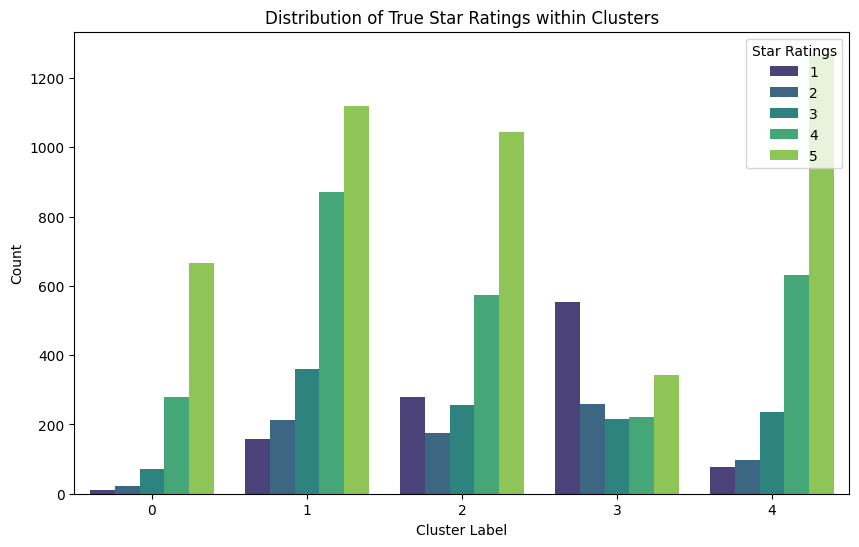

In [43]:
import seaborn as sns

# Plot distribution of true star ratings within each cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster_label', hue='stars', data=yelp_df, palette='viridis')
plt.title('Distribution of True Star Ratings within Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.legend(title='Star Ratings', loc='upper right')
plt.show()

In [47]:
from sklearn.metrics import silhouette_score

# Compute silhouette score
silhouette_avg = silhouette_score(sentence_vectors, cluster_labels)

print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.15160341950536962
